# Lab 3 — dimensionality reduction

**Group:** W

**Names:**

* Olivier Cloux
* Thibault Urien
* Saskia Reiss

In [1]:
# Given imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk

# Import panda that is easier to use than dicts
import pandas as pd

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
# Let's see whats inside those files to use them later.
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 1
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 1
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 1
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 1

{"tagId": 1128, "tag": "zombies"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


### Introduction to the Data
To begin this lab, we choose to answer to the first questions asked in the handout, which are:
* How many different movies are there? How many tags, tag scores, movie ratings?
* How many movies have at least one tag?
* How many different movie genres are there?
* What are the shortest and longest movie titles? Tag names?

Note that we use panda, as we had a few problems with dictionnaries that we could not resolve. The Data Frames given by Panda being quite easy to use too.

In [4]:
#Data Frame of all tags ID
data_genome_tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2nameDF = pd.DataFrame(data_genome_tags.map(itemgetter("tagId", "tag")).collect(),columns = ["tagId", "tag"])
#tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

# Data Frame of all movies and genres
data_movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
moviesDF = pd.DataFrame(data_movies.map(itemgetter("genres", "movieId", "title")).collect(),columns=["genres", "movieId", "title"])
genresListsDF = pd.DataFrame(data_movies.map(itemgetter("genres")).collect())
genresDF = pd.DataFrame(genresListsDF.values.flatten()).drop_duplicates().reset_index() #keep unique genres only

# Data Frame of all tag scores
data_genome_scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
tagScoresDF = pd.DataFrame(data_genome_scores.map(itemgetter("relevance", "tagId", "movieId")).collect(), columns=["relevance", "tagId", "movieId"])

#Data Frame of all ratings
data_ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
# data_ratings.groupBy(lambda x : x[0])
# #Still too big to call collect()# ratingsDF = pd.DataFrame((data3.groupBy(lambda x : x[0])).collect())

In [5]:
#Number of tags
print('There are',
      len(genresDF),'genres,',
      len(tag2nameDF),'tags', 
      data_ratings.count(),'ratings,', 
      len(moviesDF),'movies and',
      len(tagScoresDF),'tag scores')

#Find longest/shortest tag name 
tagLen = tag2nameDF.tag.map(len)
print('Longest tag name :',tag2nameDF.loc[tagLen.argmax(), 'tag'])
print('Shortest tag name :',tag2nameDF.loc[tagLen.argmin(), 'tag'])

#Find longest/shortest movie name
titleLen = moviesDF.title.map(len)
print('Longest film name :',moviesDF.loc[titleLen.argmax(), 'title'])
print('Shortest film name :',moviesDF.loc[titleLen.argmin(), 'title'])

#Number of movies and their tags
filmsWithTag = tagScoresDF.drop_duplicates(subset="movieId")['movieId']
print('There is a total of',len(moviesDF),'movies, of which', len(filmsWithTag),'have at least one tag')

There are 21 genres, 1128 tags 20000263 ratings, 27278 movies and 11709768 tag scores
Longest tag name : oscar (best writing - screenplay written directly for the screen)
Shortest tag name : 3d
Longest film name : Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)
Shortest film name : M (1931)
There is a total of 27278 movies, of which 10381 have at least one tag


#### Summary of above cell :
There are 27'278 movies, 20'000'263 ratings, 1'128 tags and 11'709'768 tag scores. There are 21 genres.

10'381 movies have at least one tag, which is a bit less than half of them.

The longest movie title is *Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)* which is 191 characters long. The shortest title is *M (2001)*.

The longest tag is *oscar (best writing - screenplay written directly for the screen)* and the shotest is *3d*

### Exercise 3.1
MxN matrix

In [6]:
# Create the M*N tag relevance matrix.
# The tags column is determied by its id.

#  M value. Count number of tag to know dimension of matrix.
tagCount = tagScoresDF.tagId.drop_duplicates().shape[0]
# Debugging line
print("There are",tagCount,"distinct tags")

# List of all movies who have at least one tag. Used to do index table, 
# to be able to map the position of movie in matric to it's Id in the table
tagged_movies_id = tagScoresDF.movieId.drop_duplicates()
# Create index over movieId. Not all movies have a tag, the movie row is determined by its position in a indexing table
tagged_movies_id_index = pd.Index(tagged_movies_id)
# N value.
tagged_movies_count = tagged_movies_id.shape[0]

# Debugging line
print("There are",tagged_movies_count,"movies with at least one tag")

# Empty matrix
tags_mx = np.zeros((tagCount,tagged_movies_count))

# Fill the matrix by iterating over our Panda table y putting the position in the index in the matrix
for tagEntry in tagScoresDF.itertuples():
    tags_mx[tagEntry.tagId-1][tagged_movies_id_index.get_loc(tagEntry.movieId)] = tagEntry.relevance


There are 1128 distinct tags
There are 10381 movies with at least one tag


Plot the variance of each dimension/tag : 
The higher the variance, the more relevant to a film it is, as it is very movie specific. A tag with low variance is 

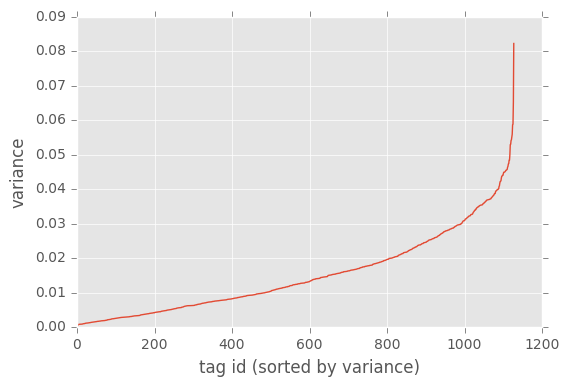

(500,) (501,)


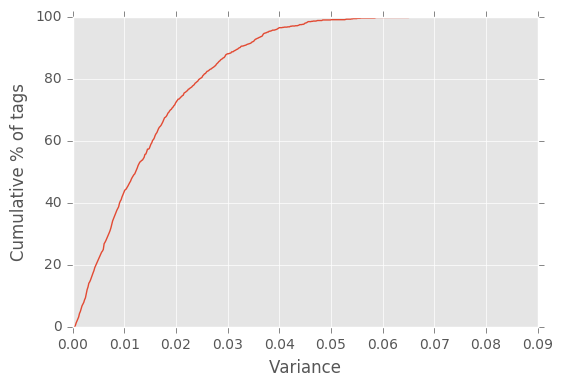

In [7]:
#Use variance function to get the variance. Sort it to get cumulative plot.
tag_variance = np.sort(np.var(tags_mx,1))

# Plot the variance by increasing order.
plt.ylabel("variance")
plt.xlabel("tag id (sorted by variance)")
plt.plot(tag_variance)
plt.show()

# Get cumulative plot.
values_var, base_var = np.histogram(tag_variance,bins=500,range=[0,max(tag_variance)])
cumulative_var = np.cumsum(values_var)
print(values_var.shape,base_var.shape)
plt.xlabel("Variance")
plt.ylabel("Cumulative % of tags")
plt.plot(base_var[:-1],cumulative_var/cumulative_var[-1]*100)
plt.show()


Plot the eigenvalue of the covariance matrix

In [ ]:
# Use the covariance function.
tag_cov = np.cov(tags_mx,rowvar=False)
# Use the eigenvalue function on the covariance.
w,v = np.linalg.eigh(tag_cov) #w = eigenvalues (sorted ascending), v = eigenvectors

# Plot the cumulative of the eigenvalues.
# values_eig, base_eig = np.histogram(tag_variance,bins=1000,range=[0,w[-1]])
cumulative_eig = np.cumsum(w)
print(len(cumulative_eig))

In [ ]:
retained_info = 2/3

ratio = cumulative_eig/cumulative_eig[-1]
numConcepts = len(ratio[ratio > 1-retained_info])
print("We need ",numConcepts," to retain ",int(100*retained_info),"% of the information")

plt.xlabel("sorted eigenvalue")
plt.ylabel("tags ID (sorted by eigenvalue of covariance)")
# plt.subplot(1,1)
plt.plot(w)
plt.yscale('log')
plt.axvline(len(w)-numConcepts)
plt.show()

As we can see above, the end of the curve is really steep on the first graph. This indicates only the first values are significative. To have a better view, we also plot a logplot. We immediately see that taking only few values (here 37), we immediately capture 2/3 of the 'energy'. 

This means that we can capture 2/3 of the dimensions with 37 concepts (instead of 1000). 

### Exercise 3.2 : Concept Space

In [11]:
five_first_dir = np.array(list(reversed(v[-5:]))).T
#🚨 index of tags start at 0 but the numpy matrix index start at 1
tag_coord_in_ffd = tags_mx @ five_first_dir 
ten_cardinal_tags_index = np.argpartition(tag_coord_in_ffd, -10,0)[-10:]
ten_anticardinal_tags_index = np.argpartition(tag_coord_in_ffd, 10,0)[:10]
ten_cardinal_tags = list(map(lambda x : tag2nameDF[tag2nameDF["tagId"].isin(list(x+1))],ten_cardinal_tags_index.T))
ten_anticardinal_tags = list(map(lambda x : tag2nameDF[tag2nameDF["tagId"].isin(list(x+1))],ten_anticardinal_tags_index.T))

In [12]:
for i in range(0,len(ten_cardinal_tags)):
    print("In categorie",i+1,"the cardinal tags are:\n",",".join(list(ten_cardinal_tags[i].tag)))
    print("And the anticardinal tags are:\n",",".join(list(ten_anticardinal_tags[i].tag)))
    print("********************************************************************************")
    

In categorie 1 the cardinal tags are:
 absurd,bad acting,bad ending,france,good acting,powerful ending,silent,snakes,special,stupid
And the anticardinal tags are:
 biting,crime gone awry,god,interracial romance,meditative,mythology,oscar (best cinematography),poetry,soccer,talking animals
********************************************************************************
In categorie 2 the cardinal tags are:
 absurd,best war films,cult film,desert,devil,great dialogue,muppets,organized crime,special,stop-motion
And the anticardinal tags are:
 better than expected,cheating,chicago,french,gilliam,homeless,schizophrenia,teen movie,teenager,wedding
********************************************************************************
In categorie 3 the cardinal tags are:
 colourful,fun,funniest movies,golf,love,mental illness,organized crime,romance,romantic,vengeance
And the anticardinal tags are:
 adventure,antarctica,art,blaxploitation,dark hero,dolphins,gangs,goofy,nocturnal,vigilantism
*******

 🥒Pickle the dictionary mapping tags name to coordinate in the 5 principle direction.🥒

In [ ]:
tagCoord = {}
i = 1
for coord in tag_coord_in_ffd :
    tagCoord[list(tag2nameDF[tag2nameDF.tagId == i].tag)[0]]=coord
    i+=1

file = open("tagCoord.pickle",'wb')
pk.dump(tagCoord,file)
    

The fi